# Aiyagari Model using EGM

This code is about 4 times faster than my previous code!!!

**Reference**

- EGM: [Pijoan-Mas's note](https://www.cemfi.es/~pijoan/Teaching_files/Notes on endogenous grid method.pdf)
- Distribution: [Violante's note](http://www.econ.nyu.edu/user/violante/NYUTeaching/QM/Fall15/Lectures/Lecture11_Distribution_Slides.pdf)
- Search index in grid: [numerical recipes](http://numerical.recipes/)

## Implimentation

### packages that we use

In [1]:
using LinearAlgebra
using Interpolations
using Profile
using BenchmarkTools
using Plots
include("myrouwenhorst.jl")
include("orderedTableSearch.jl")
using Main.orderedTableSearch: locate, hunt
pyplot()

Plots.PyPlotBackend()

### Define model parameters and settings

In [2]:
struct Model{TI<:Integer,TF<:AbstractFloat}
    #primitive params
    β::TF
    μ::TF
    b ::TF
    α::TF
    δ::TF
    σ::TF
    ρ::TF
    
    #asset grid
    na::TI
    a2grid::Array{TF,1}
    fna::TI
    agrid_fine::Array{TF,1}
    
    #shock grid
    nz::TI
    zgrid::Array{TF,1}
    Π::Array{TF,2}
    #labor supply
    L::TF
    #iteration settings
    maxiter::TI
    tol::TF
    dp_tol::TF
    dist_tol::TF

end

In [3]:
function Aggregate_Labor(zgrid,Π)
    
    # use eigen vector method to compute aggregate labor
    trans = Array(Π')
    F = eigen(trans)
    vals, vecs = F
    _, ind_val  = findmin(abs.(vals.-1.0))
    @views probst = vecs[:, ind_val]./sum(vecs[:, ind_val])
    L = dot(probst,zgrid)
    return L
end

Aggregate_Labor (generic function with 1 method)

In [4]:
function Construct(
    #Set params
    β = 0.96,
    μ = 3.0,
    b  = 0.0,
    α = 0.36,
    δ = 0.08,
    σ = 0.4, #standard deviation of error_t
    ρ = 0.3,
    a2min = 0.0,
    a2max = 40.0)
    
    # create asset grid
    na = 300
    dist_grid  = (a2max-(a2min-b))/(na-1).^2 # distance between points.
    indices   = collect(Int64,1:na) # indices of grid
    a2grid = (a2min - b).+ dist_grid*(indices.-1).^2; # asset grid
    fna = 2000
    dist_grid  = (a2max-(a2min-b))/(fna-1).^2 # distance between points.
    indices   = collect(Int64,1:fna) # indices of grid
    agrid_fine = (a2min - b).+ dist_grid*(indices.-1).^2; # asset grid
   # create shock grid
    nz = 7 # number of grid 
    zgrid,Π = myrouwenhorst(nz,ρ,σ)
    zgrid = exp.(zgrid)

    # compute labor supply
    L= Aggregate_Labor(zgrid,Π)
    
    # iteration settings
    maxiter = 3000
    tol = 1e-6 # GE loop
    dp_tol = 1e-8 # DP loop
    dist_tol = 1e-8 # distribution loop
    
    return model = Model(β,μ,b ,α,δ,σ,ρ,na,a2grid,fna,agrid_fine,
                           nz,zgrid,Π,L,maxiter,tol,dp_tol,dist_tol)
    
end

Construct (generic function with 10 methods)

### Computing invariant distribution

In [5]:
@inline function Compute_invariant!(m::Model,Λ0::Array{Float64,2},itp_pol::Array{Float64,2})
        
        
        Λ1 = zeros(m.fna,m.nz)
        
        lb = m.agrid_fine[1]
        ub = m.agrid_fine[end]
        
        for density_iter in 1 : m.maxiter
            i_k = 1
            frac = 0.0
            @inbounds for (i_z, v_z) in enumerate(m.zgrid)
                prev_ind =  1
                @inbounds for (i_a, v_a) in enumerate(m.agrid_fine)           
                    val =itp_pol[i_a,i_z]
                    if val <= lb
                        frac = 0.0
                        i_k = 1
                        
                    elseif val >= ub 
                        frac = 1.0
                        i_k = m.fna -1
                    else
                        i_k =hunt(val,m.agrid_fine,prev_ind)
                        prev_ind = i_k
                        d = m.agrid_fine[i_k+1] - m.agrid_fine[i_k]  
                        frac = (val-m.agrid_fine[i_k])/d
                        
                    end
                    @inbounds for i_nextz in 1: m.nz
                        trans_dist = Λ0[i_a,i_z]*m.Π[i_z,i_nextz]　
                        Λ1[i_k,i_nextz] += (1.0 -frac) * trans_dist
                        Λ1[i_k+1,i_nextz] += frac * trans_dist
                    end
                    
                end
            end

            density_err = maximum(abs,Λ1-Λ0)
           
            Λ0 = copy(Λ1)
            Λ1 = zeros(m.fna,m.nz)
                    
            # Check convergence.
            if density_err < m.dist_tol
                break
            end
            if density_iter >= m.maxiter
                println("Density iteration does not converge")
            end
        end
    
    return Λ0
end

Compute_invariant! (generic function with 1 method)

In [6]:
@inline function Aggregate!(m::Model,Λ0::Array{Float64,2})
    
    K1 = 0.0
    @inbounds for z in 1:m.nz
        @inbounds @simd for i in 1:m.fna
            K1 += m.agrid_fine[i] * Λ0[i,z]
        end
    end
    
    return K1
end

Aggregate! (generic function with 1 method)

### updating part in EGM

In [7]:
@inline function policyinterp(m::Model,r0::AbstractFloat,w0::AbstractFloat,a1::Array{Float64,2},
                      pol_c::Array{Float64,2},pol_c_u::Array{Float64,2})
      
    #Update the consumption policy function
    b = m.a2grid[1]
    @inbounds for (i_z, v_z) in enumerate(m.zgrid)
        prev_ind = 1
        @views searched_grid =a1[:,i_z]
        @inbounds for (i_a, v_a) in enumerate(m.a2grid)
            if v_a <= a1[1, i_z] # case where you are constrained
                pol_c_u[i_a, i_z] = (1.0+r0)*v_a + w0*v_z - b

            elseif  v_a >= a1[end, i_z] # out of the range (to the right), linearly extrapolate
                d =(v_a-a1[end, i_z])*(pol_c[end, i_z] - pol_c[end-1, i_z])/(a1[end, i_z]-a1[end-1, i_z])
                pol_c_u[i_a,i_z] = pol_c[end, i_z] +  d
                
            else # inside the range, linearly interpolate
                ind = hunt(v_a , searched_grid , prev_ind)
                prev_ind = ind
                ind1  = ind + 1
                d = (v_a-a1[ind, i_z])*(pol_c[ind1, i_z] - pol_c[ind, i_z])/(a1[ind1, i_z]-a1[ind, i_z])
                pol_c_u[i_a, i_z] = pol_c[ind, i_z] + d
            end    
        end
    end
    return pol_c_u
end

policyinterp (generic function with 1 method)

### main function

In [8]:
function main(m::Model)
    
    # utility function
    u(c::Float64) = c^(1.0-m.μ)/(1.0-m.μ)
    @inline u′(c::Array{Float64,2}) = (1.0./c).^(m.μ)
    @inline u′_inv(c::Array{Float64,2}) = (1.0./c).^(1.0/m.μ)
    
    # for convenience
    a2mat = repeat(m.a2grid,1,m.nz)
    zmat = repeat(m.zgrid',m.na)

    # initialize asset matrices 
    a1= zeros(m.na,m.nz) # endogenously determined current asset
    wealth = zeros(m.na,m.nz) # wealth matrix

    # initialize consumption matrices
    B = zeros(m.na,m.nz) # RHS of euler equation 
    ctil =zeros(m.na,m.nz) # endogenously determined current consumption
    
    # initialize policy functions 
    pol_a =zeros(m.na,m.nz) # policy function for consumption
    pol_c = ones(m.na,m.nz)# initial guess for consumption
    pol_c1 =zeros(m.na,m.nz) # updated policy function for consumption
    itp_pol = zeros(m.fna,m.nz)
    # probability density function
    Λ0 = ones(m.fna,m.nz)./(m.fna*m.nz) # initial guess
    #Λ1 = zeros(m.fna,m.nz) # updated distribution

    #iteration settings
    it =0
    err_k = 10.0
    
    # initial guess
    K0 = 6.0

    #= 1. GE loop =#
    while err_k > m.tol
          
        # compute factor price
        r0 = m.α*((m.L/K0)^(1.0-m.α)) -m.δ
        w0 = (1.0-m.α)*((K0/m.L)^m.α)  

        #= 2. Solving indivisual problem =#
        for iter in 1:m.maxiter
            # compute RHS of Euler equation
            @fastmath B = u′(pol_c) *(m.β*(1.0+r0)*m.Π')
            # compute current consumption
            @fastmath ctil = u′_inv(B)

            # compute endogenous asset matrix
            a1 =(a2mat + ctil - w0*zmat .- r0*m.b )./(1.0+r0)
                        
            pol_c1 = policyinterp(m,r0,w0,a1,ctil,pol_c1) #update policy
            err = maximum(abs,pol_c1-pol_c)
            pol_c =copy(pol_c1)

            if err < m.tol
                wealth = (1.0+r0)*a2mat + w0*zmat
                pol_a = wealth - pol_c
                break
            end
        end
        
        #= 3. Compute invariant distribution  =#
        @inbounds for i_z in 1:m.nz
            @views pol_itp = LinearInterpolation(m.a2grid,pol_a[:,i_z],extrapolation_bc = Line())
            @views itp_pol[:,i_z] = pol_itp.(m.agrid_fine)
        end
        Λ0 = Compute_invariant!(m,Λ0,itp_pol)

        
        #= 4. Aggregate and update capital=#
        K1=Aggregate!(m,Λ0)    
        K0 = 0.9*K0 +0.1*K1
    
        # update error 
        err_k = abs(K0-K1)
       
        it +=1
        if it == m.maxiter
            println("the model cannot converge in $it times iteration")
            break
        end
    end

    return K0,Λ0, pol_a, pol_c
end

main (generic function with 1 method)

### compute model

In [9]:
m = Construct();

In [10]:
K0,Λ0, pol_a, pol_c　= main(m)

(6.496245650183122, [4.67055e-5 0.00018851 … 2.84958e-5 2.8411e-6; 0.0 0.0 … 0.0 0.0; … ; 1.26682e-10 1.1057e-9 … 3.4053e-9 6.71779e-10; 1.50901e-9 1.38029e-8 … 6.01803e-8 1.36192e-8], [0.0 0.0 … 1.15456 2.03811; 0.0 0.0 … 1.15497 2.03854; … ; 38.739 38.9051 … 40.6131 41.5545; 39.0055 39.1716 … 40.8796 41.821], [0.435506 0.613314 … 1.25778 1.35913; 0.435969 0.613777 … 1.25783 1.35917; … ; 2.81808 2.82986 … 2.92087 2.96433; 2.82805 2.83983 … 2.93084 2.9743])

## Converence and equilibrium check

In [11]:
#= settings for  checking convergence =#
itp_pol = zeros(m.fna,m.nz)
@inbounds for i_z in 1:m.nz
            @views pol_itp = LinearInterpolation(m.a2grid,pol_a[:,i_z],extrapolation_bc = Line())
            @views global itp_pol[:,i_z] = pol_itp.(m.agrid_fine)
end
K1  = 0.0
for z in 1:m.nz
    for i in 1:m.fna
        global K1 += itp_pol[i,z]*Λ0[i,z]
    end
end

itp_pol = zeros(m.fna,m.nz)
@inbounds for i_z in 1:m.nz
            @views pol_itp = LinearInterpolation(m.a2grid,pol_c[:,i_z],extrapolation_bc = Line())
            @views global itp_pol[:,i_z] = pol_itp.(m.agrid_fine)
end
C  = 0.0
for z in 1:m.nz
    for i in 1:m.fna
        global C += itp_pol[i,z]*Λ0[i,z]
    end
end

In [12]:
#= Check  convergence and equilibrium conditions =#
# check whether aggregate capital is stationary
err_stationary = abs(K1-K0)
# check market clearing condition
f(K,L) = K^m.α*L^(1-m.α)
err_goods = f(K0,m.L) +(1-m.δ)*K0 -C -K1
r =  m.α*((m.L/K0)^(1.0-m.α)) -m.δ
complete_r = 1.0/m.β -1
diff_r = r - complete_r

println("stationarity error: $err_stationary")
println("Market clearing condition error: $err_goods")
println("difference of rental rate: $diff_r")
println("equilibrium rental rate: $r")

stationarity error: 4.573166557442221e-6
Market clearing condition error: -9.825934466078934e-7
difference of rental rate: -0.006715031468533084
equilibrium rental rate: 0.03495163519813366


### Speed and Memory allocation

In [13]:
@time main(m);

  3.629278 seconds (269.40 k allocations: 2.047 GiB, 5.43% gc time)


## Plotting results

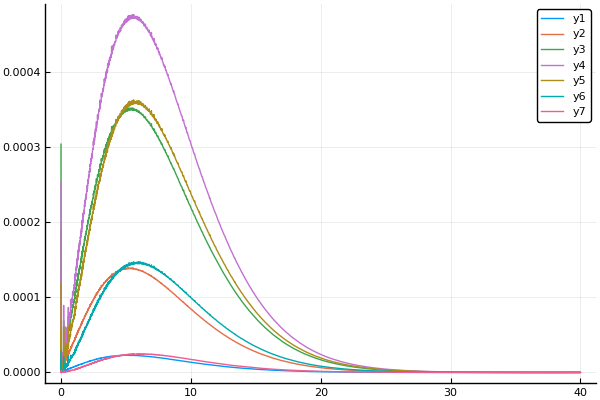

In [15]:
plot(m.agrid_fine,Λ0)

In this figure, distribution is not smooth at the left side of distribution.

The reason is that some agents are constrained.

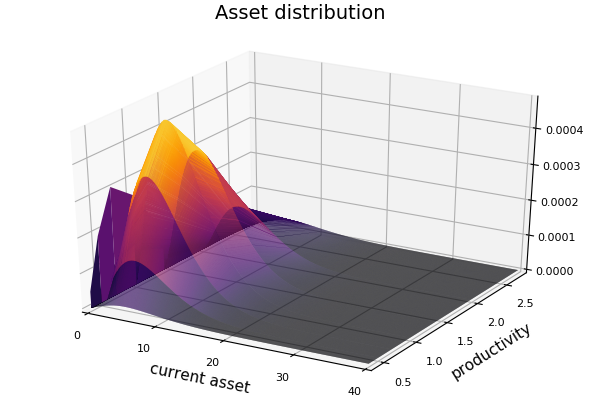

In [16]:
plot(m.agrid_fine,m.zgrid,Λ0',seriestype=:surface,legend=:none)
title!("Asset distribution")
ylabel!("productivity")
xlabel!("current asset")

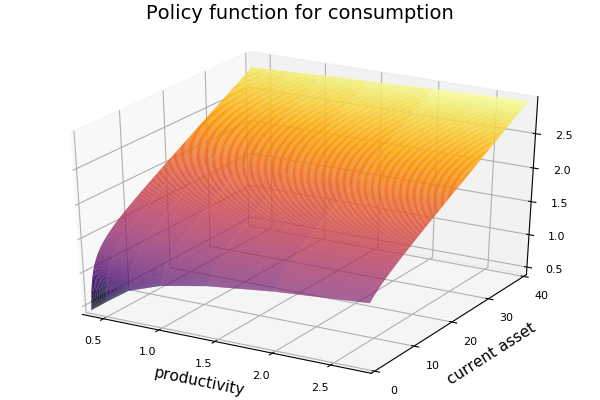

In [17]:
plot(m.zgrid,m.a2grid,pol_c,seriestype=:surface,legend=:none)
title!("Policy function for consumption")
xlabel!("productivity")
ylabel!("current asset")

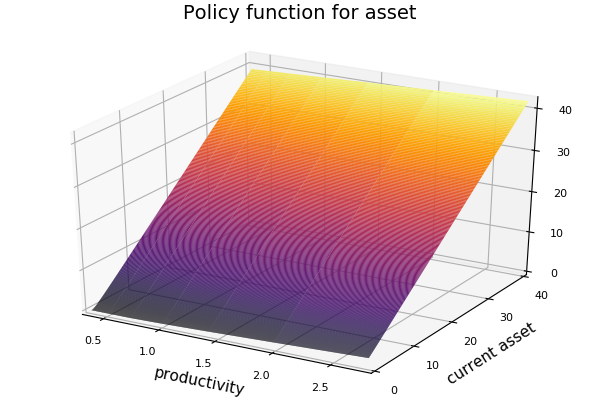

In [18]:
plot(m.zgrid,m.a2grid,pol_a,seriestype=:surface,legend=:none)
title!("Policy function for asset")
xlabel!("productivity")
ylabel!("current asset")